# Late robustness

During the model training, we activate the robustness term only after the model expresses the basic topology of the data
In the robustness phase the decision boundaries are then diffused and robustified

In [4]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
import numpy as np

# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 


torch.backends.cudnn.deterministic = True
seed = np.random.randint(1,200)
# seed = 56
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
print(seed)
g = torch.Generator()
g.manual_seed(seed)
print("done")

118
done



# Data preparation

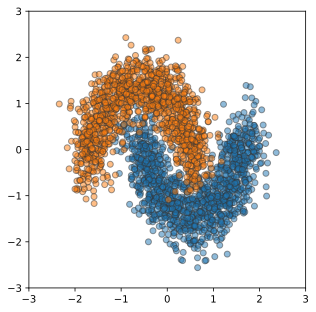

done


In [5]:
data_noise = 0.2
plotlim = [-3, 3]
subfolder = 'traj_moons'


from models.training import create_dataloader
dataloader, dataloader_viz = create_dataloader('moons', noise = data_noise, plotlim = plotlim, random_state = seed, label = 'vector')
print("done")

## Model dynamics

In [6]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE

#for neural ODE based networks the network width is constant. In this example the input is 2 dimensional
hidden_dim, data_dim = 2, 2 
augment_dim = 0

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 20, 20
bound = 0.
fp = False #this recent change made things not work anymore
cross_entropy = False
turnpike = False

non_linearity = 'tanh' #'relu' #
architecture = 'inside' #outside

## Training and generating level sets

In [7]:

num_epochs = 80 #number of optimization runs in which the dataset is used for gradient decent
eps = 0.2

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
anode = NeuralODE(device, data_dim, hidden_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3) 

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
rnode = NeuralODE(device, data_dim, hidden_dim, augment_dim=0, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_rnode = torch.optim.Adam(rnode.parameters(), lr=1e-3) 

In [8]:
from models.training import doublebackTrainer

trainer_anode = doublebackTrainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps_comp = 0.2) 
trainer_anode.train(dataloader, num_epochs)


Iteration 0/38
Loss: 2.683

Iteration 10/38
Loss: 2.435

Iteration 20/38
Loss: 2.687

Iteration 30/38
Loss: 2.178
Epoch 1: 2.502

Iteration 0/38
Loss: 1.835

Iteration 10/38
Loss: 1.422

Iteration 20/38
Loss: 1.573

Iteration 30/38
Loss: 1.401
Epoch 2: 1.515

Iteration 0/38
Loss: 1.283

Iteration 10/38
Loss: 1.426

Iteration 20/38
Loss: 1.436

Iteration 30/38
Loss: 1.472
Epoch 3: 1.390

Iteration 0/38
Loss: 1.303

Iteration 10/38
Loss: 1.533

Iteration 20/38
Loss: 1.177

Iteration 30/38
Loss: 1.284
Epoch 4: 1.291

Iteration 0/38
Loss: 1.148

Iteration 10/38
Loss: 1.026

Iteration 20/38
Loss: 1.322

Iteration 30/38
Loss: 1.247
Epoch 5: 1.199

Iteration 0/38
Loss: 1.096

Iteration 10/38
Loss: 1.237

Iteration 20/38
Loss: 1.075

Iteration 30/38
Loss: 0.981
Epoch 6: 1.125

Iteration 0/38
Loss: 0.941

Iteration 10/38
Loss: 0.840

Iteration 20/38
Loss: 1.235

Iteration 30/38
Loss: 1.189
Epoch 7: 1.064

Iteration 0/38
Loss: 1.036

Iteration 10/38
Loss: 0.895

Iteration 20/38
Loss: 0.903

Ite

In [9]:
for X_viz, y_viz in dataloader_viz:
    X_viz = X_viz[0:5]
    break

trajectories = anode.flow.trajectory(X_viz, 10).detach()
print(X_viz)
print(trajectories.size()) #time is in the first coordinate

tensor([[-0.4179, -1.3306],
        [-0.2521,  1.8299],
        [ 1.6025, -0.9923],
        [-0.4889,  1.0938],
        [ 0.4510, -0.3862]])
torch.Size([10, 5, 2])


## Lyapunov exponent computation - rough approximation

In [10]:
'''
input: two trajectories x(t), y(t) where each has size (x_dim,len_t)
output: maximum lyapunov exponent for each time t, size (1,len_t)'''
def le(x,y,t):
    d = x - y
    d = torch.linalg.norm(x - y, dim = 0)
    # print(f'{d.shape = }')
    d = d/d[0]
    d = np.log(d)
    

    d = d/t
    return d



'''
Compute the maximum Lyapunov exponent with initial value tolerance eps
input: 
trajectories of size (x_amount,x_amount,x_dim,time_dim)
each trajectory has initial value x_0 = traj[i,j,:,0]

output:
MLE for each trajectory as averaged LE for all initial values that is eps close to the initial value
output size (x_amount,x_amount,t_dim)
'''
def MLE(traj, t, eps = 0.1):
    x_amount = traj.size(0)
    x_amount, y_amount, x_dim, t_dim = traj.shape
    le_val = torch.zeros((x_amount, y_amount, t_dim)) 
    print(f'{le_val.shape = }')
    for i in range(x_amount):
        for j in range(y_amount):
            count = 0
            for i_comp in range(x_amount):
                for j_comp in range(y_amount):
                    if (torch.norm(traj[i,j,:,0] - traj[i_comp,j_comp,:,0]) < eps and not(i == i_comp and j == j_comp)):
                        count += 1
                        le_val[i,j] += le(traj[i,j,:,:],traj[i_comp,j_comp,:,:],t)
                        #print('avg le update with count ',count,' and value ',le_val[i,j,-1])
            if count > 1:
                le_val[i,j,:] = le_val[i,j,:]/count
    return le_val



## Computation of the Maximal Lyapunov Exponent by integration 

In [132]:
'''
In this section, the set of function definitions needed to compute the Maximal Lyapunov Exponent by direct integration
(i.e. the nalaytical way) are coded.
'''

import numpy as np
import scipy

def linear_dynamics(node):
    '''
    Takes as input a nODE and return the augmented (flattened) linear system (f(x), Df(x)Y) as a 
    function of (x,Y) and t (flattened)
    '''
    f_x = node.flow.dynamics.forward
    
    """def numerical_der(f, x, t, eps = 10**-5):
        '''
        Takes the numerical derivatives of a function f(t, x) w.r.t. x 
        '''
        x_len = x.size
        Df_x = np.zeros((x_len,x_len))
        for i in range(x_len):
            x_eps = np.copy(x)
            x_eps[i] = x[i] + eps
            f_of_x = f(t, torch.from_numpy(x).type(torch.float32))
            vector = (f(t, torch.from_numpy(x_eps).type(torch.float32))-f_of_x)/eps
            Df_x[i,:] = vector.detach().numpy()
        return Df_x
    """
    
    def composed_lin_ODE(x_and_Y,t):
        '''
        Build the extended right hand side of the augmented (flattened) linear system (f(x), Df(x)Y)
        '''
        size_x = node.data_dim
        x = x_and_Y[:size_x]
        Y = np.reshape(x_and_Y[size_x:], [size_x, size_x])
        x_torch = torch.from_numpy(x).type(torch.float32)
        x_torch.requires_grad=True
        f_x_torch = f_x(t, x_torch)
        def f_x_t(x):
            return f_x(t, x)
        Df_x = torch.autograd.functional.jacobian(f_x_t, x_torch) # is it numerical?
        # print(Df_x_grad)
        # Df_x_num = numerical_der(f_x, x, t)
        # print(Df_x_grad.numpy(),'\n', Df_x_num,'\n', Df_x_grad-Df_x_num)
        f_of_x = f_x_torch.detach().numpy()
        Dfx_Y = np.matmul(Df_x.numpy(), Y).flatten()
        rhs = np.concatenate((f_of_x, Dfx_Y))
        return rhs
    
    return composed_lin_ODE


def local_FTLE(node, x, integration_time, dt = 0.05):
    '''
    Full Maximal Lyapunov exponent computation, based on the lynear_dynamics function
    '''
    time_array = np.arange(0, integration_time, dt)
    Jac = np.identity(x.size)
    x_and_Jac_t = np.concatenate((x,Jac.flatten()))
    select_Jac_int = lambda mat: np.reshape(mat[-1,x.size:],[x.size,x.size])
    select_x_int = lambda mat: mat[-1,:x.size:]
    L = np.zeros_like(x)
    for i in range(iters):
        x_and_Jac_t = scipy.integrate.odeint(linear_dynamics(node), x_and_Jac_t, time_array_iter)
        Jac_t = select_Jac_int(x_and_Jac_t)
        Q_t, R_t = np.linalg.qr(Jac_t)
        x_and_Jac_t = np.concatenate((select_x_int(x_and_Jac_t),Q_t.flatten()))
        L += np.linalg.log(np.diagonal(R_t))
    # L = np.reshape(forward_integral[-1,x.size:],[x.size,x.size])
    try:
        K = np.matmul(L, L.transpose())
        logK = scipy.linalg.logm(K)
        lyap_exp = np.linalg.eig( 1/(2*integration_time) * logK)
    except:
        K = np.matmul(L, L.transpose())
        print(K)
        print(scipy.linalg.logm(K))
        print( 1/(2*integration_time) * np.log(np.matmul(L, L.transpose())))
    return np.max(lyap_exp.eigenvalues)

In [125]:
import time

# sanity check:
l = local_FTLE(anode, np.array([0.1,-0.5]), 1, 0.1)

x_amount = 10
integration_time = T
dt = 0.1

x = np.linspace(-2,2,x_amount)
y = np.linspace(-2,2,x_amount)
X, Y = np.meshgrid(x, y)
XY = np.array([X.flatten(), Y.flatten()])

lyap = np.zeros(x_amount**2)
start_time = time.time()
for i in range(x_amount**2):
    # print(XY[:,i])
    lyap[i] = local_FTLE(anode, XY[:,i], integration_time, dt)
    iteration_time = time.time() - start_time
    if np.mod(i, 10) == 0:
        print(i+1,' out of ', x_amount**2, ' after ', iteration_time)
    # print(lyap)
lyap = np.reshape(lyap, (x_amount,x_amount))
print(lyap)

1  out of  100  after  0.9894018173217773
11  out of  100  after  10.528117895126343
21  out of  100  after  20.20782494544983
31  out of  100  after  30.095266103744507
41  out of  100  after  40.86214280128479
51  out of  100  after  51.1082558631897
61  out of  100  after  61.068933725357056
71  out of  100  after  71.10954189300537
81  out of  100  after  81.14205384254456
91  out of  100  after  91.3166127204895
[[0.06590551 0.06590551 0.06590551 0.06590551 0.06590551 0.06590551
  0.06590551 0.06590551 0.06590551 0.06590551]
 [0.06590551 0.06590551 0.06590551 0.06590551 0.06590551 0.06590551
  0.06590551 0.06590551 0.06590551 0.06590551]
 [0.06590551 0.06590551 0.06590551 0.06590551 0.06590551 0.06590551
  0.06590551 0.06590551 0.06590551 0.06590551]
 [0.06590551 0.06590551 0.06590551 0.06590551 0.06590551 0.06590551
  0.06590551 0.06590551 0.06590551 0.06590551]
 [0.06590551 0.06590551 0.06590551 0.06590551 0.06590551 0.06590551
  0.06590551 0.06590551 0.06590551 0.06590551]
 [0.

In [126]:
# testing the auto grad function 
testing = False
if testing:
    w = torch.rand(2,2)
    b = torch.rand(2)
    print(w, b)
    def exp_reducer(x):
         return torch.matmul(w, x) + b

    inputs = torch.rand(2)

    print(torch.autograd.functional.jacobian(exp_reducer, inputs))

In [127]:
# TESTING 
testing = False
if testing:
    x = np.array([1., 2.]) # point where we compute the MLE
    Jac = np.identity(2)     # vector with appropriate size
    x_and_Jac = np.concatenate((x,Jac.flatten())).astype(np. double)
    dt = 0.1
    integration_time = 1.
    time_array = np.arange(0, integration_time, dt)
    debug_MLE = False
    f_x = anode.flow.dynamics.forward
    f_x(integration_time, torch.from_numpy(x).type(torch.float32)) # this now works
    CLO = linear_dynamics(anode)
    CLO(x_and_Jac, integration_time)

    out = scipy.integrate.odeint(linear_dynamics(anode), x_and_Jac, time_array)
    # out has one entry for each time

    # we are only interested in the last time integration, that we reshape as a matrix
    L = np.reshape(out[-1,2:],[2,2])

    print('\nL = ', L)
    print('\nlog( L * L.T )= ', np.log(np.matmul(L, L.transpose())))
    
    lyap_exp = np.linalg.eig( 1/(2*integration_time) * np.log(np.matmul(L, L.transpose())))
    
    print('\nLyap exps = ', lyap_exp.eigenvalues)
    
    # using the full function
    l = local_FTLE(anode, np.array([0.1,-0.5]), 1)
    print('Local FTLE = ', l)

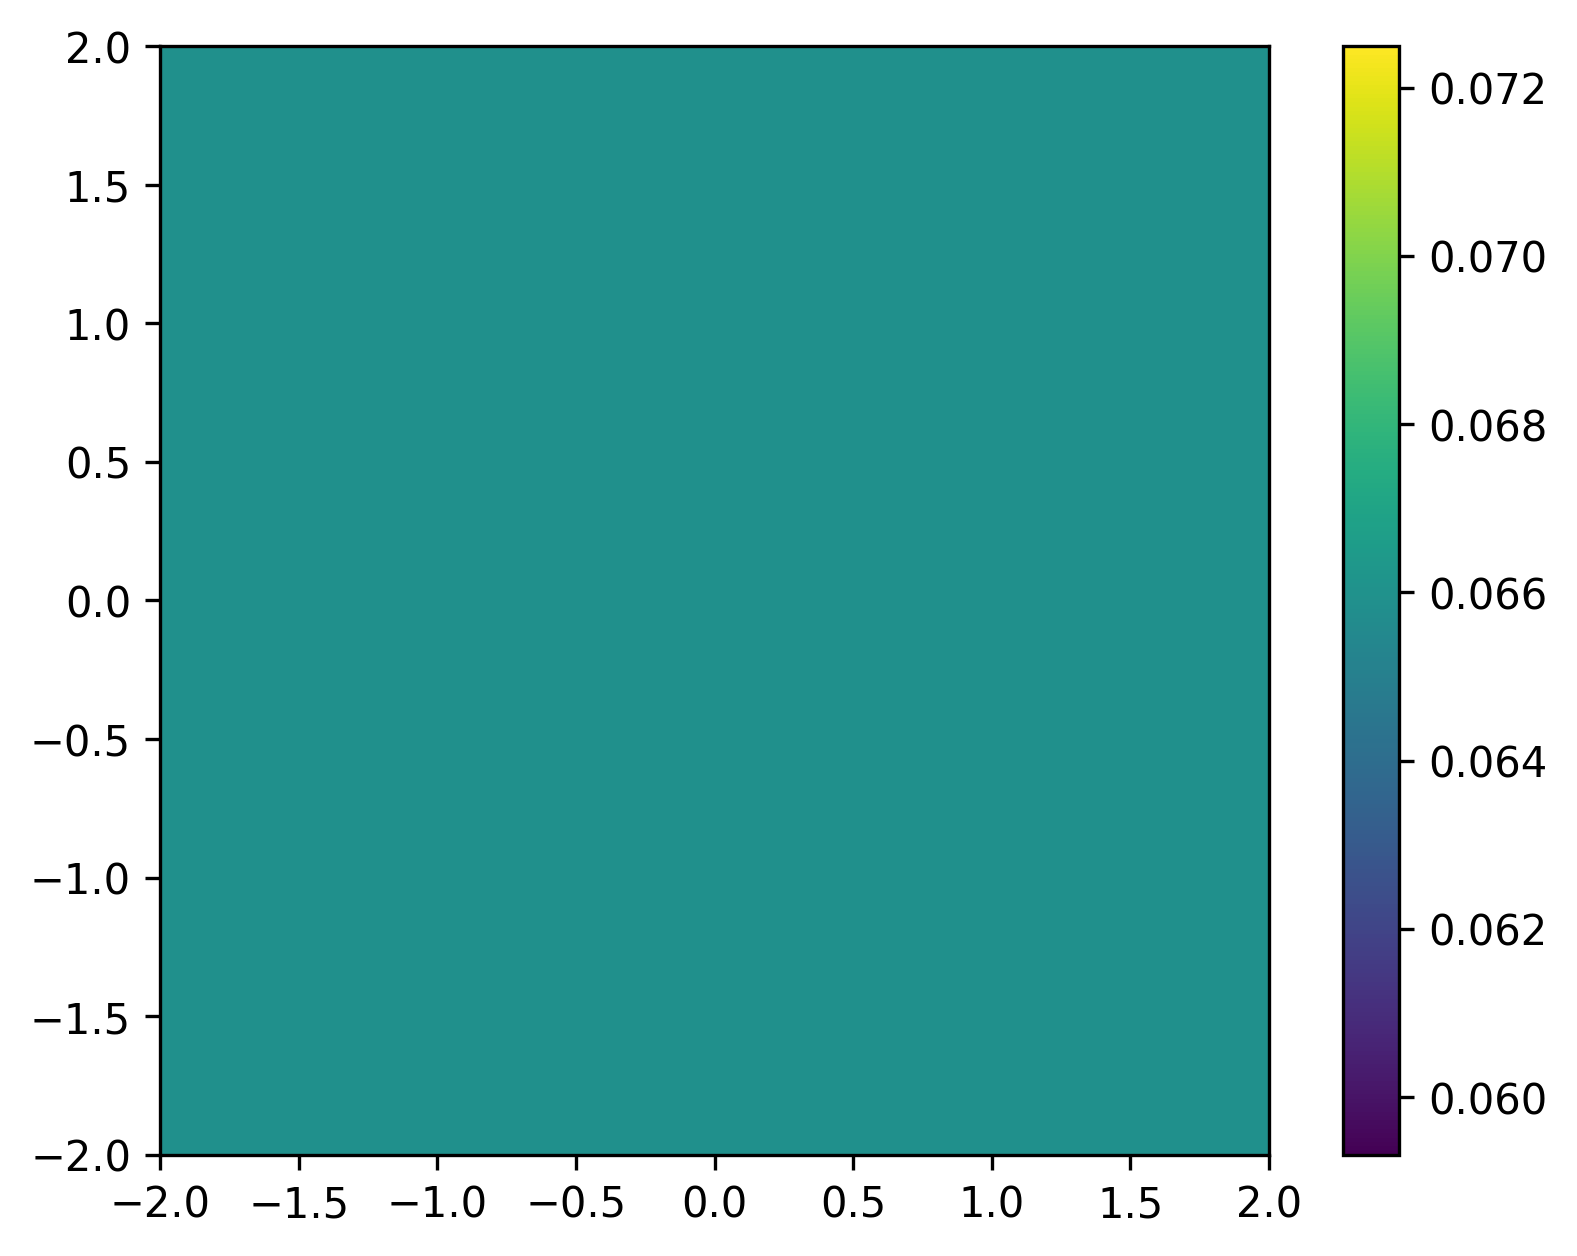

In [131]:
# Create heatmap using imshow
from IPython.display import Image
anodeimg = plt.imshow(np.rot90(lyap), origin='upper', extent=(-2, 2, -2, 2), cmap='viridis')
vmin, vmax = anodeimg.get_clim()
plt.colorbar()  # Show color scale
plt.savefig('MLE_analytic.png',bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
plt.close()

img1 = Image('MLE_analytic.png', width = 400)

display(img1)

In [ ]:
from plots.gifs import trajectory_gif

#the function trajectory_gif creates the evolution trajectories of the input data through the network
#the passing time corresponds to the depth of the network

for X_viz, y_viz in dataloader_viz:
    trajectory_gif(anode, X_viz[0:50], y_viz[0:50], timesteps=num_steps, filename = 'trajectory.gif', axlim = 8, dpi = 100)
    trajectory_gif(rnode, X_viz[0:50], y_viz[0:50], timesteps=num_steps, filename = 'trajectory_db.gif', axlim = 8, dpi = 100)
    break

#Display of the generated gif
traj = Image(filename="trajectory.gif")
rtraj = Image(filename="trajectory_db.gif")
display(traj, rtraj)

In [ ]:
from IPython.display import Image
from plots.plots import comparison_plot
# traj = Image(filename="trajectory19.png", retina = True)
# rtraj = Image(filename="trajectory_db19.png", retina = True)
# display(traj, rtraj)

comparison_plot("trajectory39.png", 'standard training', "trajectory_db39.png", 'robust training', 'traj_comp.png')
display(Image('traj_comp.png', width = 800))

I want to visualize the separation boundary in the final linear layer.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import torch
import torch.nn as nn
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
from matplotlib.colors import to_rgb
import imageio

from matplotlib.colors import LinearSegmentedColormap
import os


@torch.no_grad()
def linlayer_levelsets(model, fig_name=None, footnote=None, contour = True, plotlim = [-2, 2]):
    
    
    x1lower, x1upper = plotlim
    x2lower, x2upper = plotlim

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    fig = plt.figure(figsize=(5, 5), dpi=100)
    
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.figtext(0.5, 0, footnote, ha="center", fontsize=10)

    
   
    model.to(device)

    x1 = torch.arange(x1lower, x1upper, step=0.01, device=device)
    x2 = torch.arange(x2lower, x2upper, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2)  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    
    preds = model.linear_layer(model_inputs)
    
    # dim = 2 means that it normalizes along the last dimension, i.e. along the two predictions that are the model output
    m = nn.Softmax(dim=2)
    # softmax normalizes the model predictions to probabilities
    preds = m(preds)

    #we only need the probability for being in class1 (as prob for class2 is then 1- class1)
    preds = preds[:, :, 0]
    preds = preds.unsqueeze(2)  # adds a tensor dimension at position 2
    
    plt.grid(False)
    plt.xlim([x1lower, x1upper])
    plt.ylim([x2lower, x2upper])

    ax = plt.gca()
    ax.set_aspect('equal') 
    
    if contour:
        colors = [to_rgb("C1"), [1, 1, 1], to_rgb("C0")] # first color is orange, last is blue
        cm = LinearSegmentedColormap.from_list(
            "Custom", colors, N=40)
        z = np.array(preds).reshape(xx1.shape)
        
        levels = np.linspace(0.,1.,20).tolist()
        
        cont = plt.contourf(xx1, xx2, z, levels, alpha=1, cmap=cm, zorder = 0, extent=(x1lower, x1upper, x2lower, x2upper)) #plt.get_cmap('coolwarm')
        cbar = fig.colorbar(cont, fraction=0.046, pad=0.04)
        cbar.ax.set_ylabel('prediction prob.')
    

    if fig_name:
        plt.savefig(fig_name + '.png', bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
        plt.clf()
        plt.close()
    # else: plt.show()
        

In [ ]:
linlayer_levelsets(anode)

In [ ]:
@torch.no_grad()
def trajectory_gif_new(model, inputs, targets, timesteps, dpi=200, alpha=0.9,
                   alpha_line=1, filename='trajectory.gif', axlim = 0):
    
    from matplotlib import rc
    from scipy.interpolate import interp1d
    rc("text", usetex = False)
    font = {'size'   : 18}
    rc('font', **font)

    if not filename.endswith(".gif"):
        raise RuntimeError("Name must end in with .gif, but ends with {}".format(filename))
    base_filename = filename[:-4]

    ## We focus on 3 colors at most
    if False in (t < 2 for t in targets): 
        color = ['mediumpurple' if targets[i] == 2.0 else 'gold' if targets[i] == 0.0 else 'mediumseagreen' for i in range(len(targets))]
    else:
        #color = ['crimson' if targets[i, 0] > 0.0 else 'dodgerblue' for i in range(len(targets))]
        color = ['C1' if targets[i] > 0.0 else 'dimgrey' for i in range(len(targets))]

    trajectories = model.flow.trajectory(inputs, timesteps).detach()
    num_dims = trajectories.shape[2]

    if axlim == 0:        
        x_min, x_max = trajectories[:, :, 0].min(), trajectories[:, :, 0].max()
        y_min, y_max = trajectories[:, :, 1].min(), trajectories[:, :, 1].max()
    else: 
        x_min, x_max = -axlim, axlim  #to normalize for rob and standard nODE
        y_min, y_max = -axlim, axlim   #
        
    if num_dims == 3:
        z_min, z_max = trajectories[:, :, 2].min(), trajectories[:, :, 2].max()
    margin = 0.1
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_min -= margin * x_range
    x_max += margin * x_range
    y_min -= margin * y_range
    y_max += margin * y_range
    if num_dims == 3:
        z_range = z_max - z_min
        z_min -= margin * z_range
        z_max += margin * z_range
        
    T = model.T 
    integration_time = torch.linspace(0.0, T, timesteps)
    
    interp_x = []
    interp_y = []
    interp_z = []
    for i in range(inputs.shape[0]):
        interp_x.append(interp1d(integration_time, trajectories[:, i, 0], kind='cubic', fill_value='extrapolate'))
        interp_y.append(interp1d(integration_time, trajectories[:, i, 1], kind='cubic', fill_value='extrapolate'))
        if num_dims == 3:
            interp_z.append(interp1d(integration_time, trajectories[:, i, 2], kind='cubic', fill_value='extrapolate'))
    
    interp_time = 20
    # interp_time = 3 #this was 5 before
    _time = torch.linspace(0., T, interp_time)

    plt.rc('grid', linestyle="dotted", color='lightgray')
    for t in range(interp_time):
        if num_dims == 2:
            fig = plt.figure()
            ax = fig.add_subplot(1, 1, 1)
            label_size = 13
            plt.rcParams['xtick.labelsize'] = label_size
            plt.rcParams['ytick.labelsize'] = label_size 
            ax.set_axisbelow(True)
            ax.xaxis.grid(color='lightgray', linestyle='dotted')
            ax.yaxis.grid(color='lightgray', linestyle='dotted')
            ax.set_facecolor('whitesmoke')
            
            plt.xlim(x_min, x_max)
            plt.ylim(y_min, y_max)
            plt.rc('text', usetex=False)
            plt.rc('font', family='serif')
            plt.xlabel(r'$x_1$', fontsize=12)
            plt.ylabel(r'$x_2$', fontsize=12)
            
            x1 = torch.arange(x_min, x_max, step=0.01, device=device)
            x2 = torch.arange(y_min, y_max, step=0.01, device=device)
            xx1, xx2 = torch.meshgrid(x1, x2)  # Meshgrid function as in numpy
            model_inputs = torch.stack([xx1, xx2], dim=-1)
            
            preds = model.linear_layer(model_inputs)
            
            # dim = 2 means that it normalizes along the last dimension, i.e. along the two predictions that are the model output
            m = nn.Softmax(dim=2)
            # softmax normalizes the model predictions to probabilities
            preds = m(preds)

            #we only need the probability for being in class1 (as prob for class2 is then 1- class1)
            preds = preds[:, :, 0]
            preds = preds.unsqueeze(2)  # adds a tensor dimension at position 2
            
            plt.grid(False)
    

            ax = plt.gca()
            ax.set_aspect('equal') 
            
            
            colors = [to_rgb("C1"), [1, 1, 1], to_rgb("C0")] # first color is orange, last is blue
            cm = LinearSegmentedColormap.from_list(
                "Custom", colors, N=40)
            z = np.array(preds).reshape(xx1.shape)
            
            levels = np.linspace(0.,1.,15).tolist()
            
            cont = plt.contourf(xx1, xx2, z, levels, alpha=0.5, cmap=cm, zorder = 0, extent=(x_min, x_max, y_min, y_max)) #plt.get_cmap('coolwarm')
            
            
            
            
            plt.scatter([x(_time)[t] for x in interp_x], 
                         [y(_time)[t] for y in interp_y], 
                         c=color, alpha=alpha, marker = 'o', linewidth=0.65, edgecolors='black', zorder=3)

            if t > 0:
                for i in range(inputs.shape[0]):
                    x_traj = interp_x[i](_time)[:t+1]
                    y_traj = interp_y[i](_time)[:t+1]
                    plt.plot(x_traj, y_traj, c=color[i], alpha=alpha_line, linewidth = 0.75, zorder=1)
            
        
        ax.set_aspect('equal')

        plt.savefig(base_filename + "{}.png".format(t),
                    format='png', dpi=dpi, bbox_inches='tight', facecolor = 'white')
        # Save only 3 frames (.pdf for paper)
        # if t in [0, interp_time//5, interp_time//2, interp_time-1]:
        #     plt.savefig(base_filename + "{}.pdf".format(t), format='pdf', bbox_inches='tight')
        plt.clf()
        plt.close()

    imgs = []
    for i in range(interp_time):
        img_file = base_filename + "{}.png".format(i)
        imgs.append(imageio.imread(img_file))
        if i not in [0, interp_time//5, interp_time//2, interp_time-1]: os.remove(img_file) 
    imageio.mimwrite(filename, imgs, duration = 500)

In [ ]:
from plots.gifs import trajectory_gif

#the function trajectory_gif creates the evolution trajectories of the input data through the network
#the passing time corresponds to the depth of the network

data_iter = iter(dataloader)
X,y = next(data_iter)
batch_size = 40

X_viz = torch.zeros_like(X[0:batch_size])
y_viz = torch.zeros(batch_size)
print(y_viz.size())
print(X_viz.size())
X_viz[:,1] = torch.linspace(-5,5,batch_size)
X_viz[:,0] = torch.tensor([0])
print(X_viz)

# plt.scatter(X_viz[:,0],X_viz[:,1])

trajectory_gif_new(anode, X_viz[0:batch_size], y_viz[0:batch_size], timesteps=num_steps, filename = 'trajectory.gif', axlim = 8, dpi = 100)
trajectory_gif_new(rnode, X_viz[0:batch_size], y_viz[0:batch_size], timesteps=num_steps, filename = 'trajectory_db.gif', axlim = 8, dpi = 100)


In [ ]:
traj = Image(filename="trajectory.gif")
rtraj = Image(filename="trajectory_db.gif")
display(traj, rtraj)

comparison_plot("trajectory19.png", 'standard training', "trajectory_db19.png", 'robust training', 'traj_comp.png')
display(Image('traj_comp.png', width = 800))

In [ ]:
for X_viz, y_viz in dataloader_viz:
    trajectory_gif_new(anode, X_viz, y_viz, timesteps=num_steps, filename = 'trajectory.gif', axlim = 8, dpi = 100)
    trajectory_gif_new(rnode, X_viz, y_viz, timesteps=num_steps, filename = 'trajectory_db.gif', axlim = 8, dpi = 100)
    break

#Display of the generated gif
traj = Image(filename="trajectory.gif")
rtraj = Image(filename="trajectory_db.gif")
display(traj, rtraj)

comparison_plot("trajectory19.png", 'standard training', "trajectory_db19.png", 'robust training', 'traj_comp.png')
display(Image('traj_comp.png', width = 800))